# Preprocessing

In [1]:
import os
import datetime as dt

import copy
import IPython
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2022-04-25 22:59:15.645854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 22:59:15.645896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Macros
BY_ZONE = False # True if you want grouping by zones (Nord, Centro, Sud, Sardegna)
BY_REGION = True # True if you want to keep single regions

In [3]:
# File name
#file_path = "../Data/dpc-covid19-ita-regioni.csv"
file_path = '../Data/dpc-covid19-ita-regioni.csv'
features_list = ["totale_ospedalizzati", "nuovi_positivi", "dimessi_guariti", "deceduti"]

# Load data
df_all = pd.read_csv(
    file_path,
    usecols = ["data", "denominazione_regione", "nuovi_positivi", "totale_ospedalizzati", "dimessi_guariti", "deceduti"],
    parse_dates = True,
)

# Convert data coulumn
df_all["data"] = pd.to_datetime(df_all["data"]).dt.date

# Keep only latest data wrt cut_date
cut_date_3 = dt.date(2022, 2, 10)    #(2022, 1, 10)
cut_date_2 = dt.date(2021, 10, 1)
cut_date_1 = dt.date(2021, 3, 1)  

df_all = df_all.loc[ ((df_all["data"] >= cut_date_1) & (df_all["data"] <= cut_date_2)) | (df_all["data"] >= cut_date_3)]

In [4]:
# Create 4 groups of regions
# NON SONO SICURO PERO': LUI CHIEDE ESPRESSAMENTE REGIONI!
if BY_ZONE:
    
    Nord = ["Emilia-Romagna", 
            "Friuli Venezia Giulia", 
            "Lombardia", 
            "P.A. Bolzano", 
            "P.A. Trento", 
            "Piemonte", 
            "Toscana", 
            "Valle d'Aosta",
            "Veneto"
           ]
    Centro = ["Abruzzo",
              "Lazio",
              "Marche",
              "Molise",
              "Umbria",
             ]

    Sud = ["Basilicata",
           "Calabria",
           "Campania",
           "Puglia",
           "Sicilia"
          ]

    Sardegna = ["Sardegna"]

    df_Nord = df_all.loc[df_all['denominazione_regione'].isin(Nord)]
    df_Nord.pop("denominazione_regione")
    df_Nord = df_Nord.groupby(["data"]).sum()
    df_Nord.reset_index(drop=False, inplace=True)

    df_Centro = df_all.loc[df_all['denominazione_regione'].isin(Centro)]
    df_Centro.pop("denominazione_regione")
    df_Centro = df_Centro.groupby(["data"]).sum()
    df_Centro.reset_index(drop=False, inplace=True)

    
    df_Sud = df_all.loc[df_all['denominazione_regione'].isin(Sud)]
    df_Sud.pop("denominazione_regione")
    df_Sud = df_Sud.groupby(["data"]).sum()
    df_Sud.reset_index(drop=False, inplace=True)

    
    df_Sardegna = df_all.loc[df_all['denominazione_regione'].isin(Sardegna)]
    df_Sardegna.pop("denominazione_regione")
    df_Sardegna = df_Sardegna.groupby(["data"]).sum()
    df_Sardegna.reset_index(drop=False, inplace=True)

In [5]:
df_tot = pd.DataFrame()

if BY_REGION:
    
    df_by_region = dict() # dictionary containing data for each regione

    regions = list(df_all.loc[:,"denominazione_regione"].unique())
    
    for reg in regions:
        
        df_by_region[reg] = df_all.loc[df_all["denominazione_regione"] == reg]
        columns_={"totale_ospedalizzati": "totale_ospedalizzati_" + reg, 
                 "nuovi_positivi": "nuovi_positivi_" + reg, 
                 "dimessi_guariti" : "dimessi_guariti_" + reg, 
                 "deceduti": "deceduti_" + reg}
        df_by_region[reg].pop("denominazione_regione")
        df_by_region[reg] = df_by_region[reg].rename(columns = columns_)
        df_by_region[reg].set_index("data", inplace = True)
       
        if df_tot.shape[0] == 0:
            df_tot = df_by_region[reg].iloc[:,1:]
        else:
            df_tot = pd.concat([df_tot, df_by_region[reg].iloc[:,1:]], axis=1)


 # RNN

## Tensorflow modified classes 

In [6]:
# FUNCTIONALITIES

# Window generator
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df=None, test_df=None,
               label_columns=None, batch_size = 32):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.batch_size = batch_size
    
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# Split window
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# plot function
def plot(self, model=None, plot_col='nuovi_positivi_Lombardia', max_subplots=32):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.figure()
    #plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

# make tf.dataset
def make_dataset(self, data, batch_size):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=batch_size,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

# Properties
@property
def train(self):
  return self.make_dataset(self.train_df, self.batch_size)

@property
def val(self):
  return self.make_dataset(self.val_df, self.batch_size)

@property
def test(self):
  return self.make_dataset(self.test_df, self.batch_size)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Training-Validation-Test sets creation

array([<AxesSubplot:xlabel='data'>, <AxesSubplot:xlabel='data'>,
       <AxesSubplot:xlabel='data'>, <AxesSubplot:xlabel='data'>],
      dtype=object)

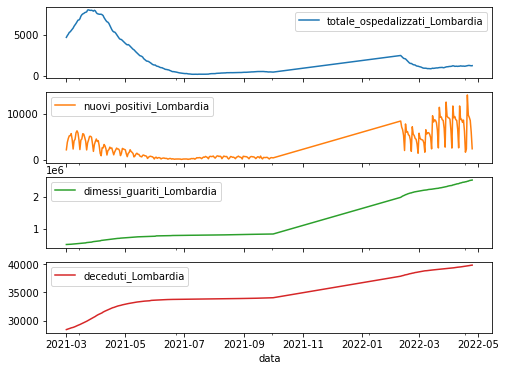

In [7]:
df_by_region['Lombardia'].plot(subplots=True)

In [8]:
regions_train = ["Lombardia"]   # name of regions to train simultaneously

NORMALIZATION = False
PCT_CHANGE = True
DIFF = False
APPLY_SMOOTHING = False
VALIDATION = True

all_df = dict()
all_df_1 = dict()
all_df_2 = dict()
train_df = dict() # dictionary of training dataFrames 
if VALIDATION:
    val_df = dict() # validation temporarily ignored
test_df = dict() # dictionary of test dataframes

OUT_STEPS = 7 # length of prediction horizon (OUTPUT OF NN)
IN_STEPS = 28 # length of input horizon (INPUT OF NN)
SHIFT = OUT_STEPS # Can be different from OUT_STEPS (to be used with care)

time_steps_for_test = OUT_STEPS # Numbers of days to keep out for the validation (in principle it should be of length: OUT_STEP+IN_STEPS), but we can use just OUT_STEPS
if VALIDATION:
    time_steps_for_validation = IN_STEPS+OUT_STEPS

# FOR THE NORMALIZATION I USE THE MEANS OF TRAIN FOR BOTH TRAINING AND TESTING
for reg in regions_train:

    mean = 0
    std = 1

    if PCT_CHANGE:

      all_df_1[reg] = copy.deepcopy(df_by_region[reg].loc[ ((df_by_region[reg].index >= cut_date_1) & (df_by_region[reg].index <= cut_date_2)) ])
      all_df_2[reg] = copy.deepcopy(df_by_region[reg].loc[ (df_by_region[reg].index >= cut_date_3)])
      all_df_1[reg] = all_df_1[reg].pct_change().dropna()
      all_df_2[reg] = all_df_2[reg].pct_change().dropna()
      all_df[reg] = pd.concat([all_df_1[reg], all_df_2[reg]], axis = 0, ignore_index = True)
    
    if DIFF:

      all_df_1[reg] = copy.deepcopy(df_by_region[reg].loc[ ((df_by_region[reg].index >= cut_date_1) & (df_by_region[reg].index <= cut_date_2)) ])
      all_df_2[reg] = copy.deepcopy(df_by_region[reg].loc[ (df_by_region[reg].index >= cut_date_3)])
      all_df_1[reg] = all_df_1[reg].diff().dropna()
      all_df_2[reg] = all_df_2[reg].diff().dropna()
      all_df[reg] = pd.concat([all_df_1[reg], all_df_2[reg]], axis = 0, ignore_index = True)
    
    if NORMALIZATION:
      mean = all_df[reg].iloc[:-time_steps_for_test,:].mean()
      std = all_df[reg].iloc[:-time_steps_for_test,:].std()
      
    all_df[reg] = ( all_df[reg] - mean ) / std

    if APPLY_SMOOTHING:
        
        window_length = 3 # MUST BE ODD; if you put 7 you obtain just the trend
        polyorder = 1 # Try also 2, 3, ...
        
        all_df[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)] = savgol_filter(
                all_df[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)],
                window_length,
                polyorder
            )
    
    if VALIDATION:
        train_df[reg] = all_df[reg].iloc[:-(time_steps_for_test + time_steps_for_validation),:]
        val_df[reg] = all_df[reg].iloc[ -(time_steps_for_test + time_steps_for_validation) : -time_steps_for_test, :]
        test_df[reg] = all_df[reg].iloc[-time_steps_for_test:,:]
    else:
        train_df[reg] = all_df[reg].iloc[:-time_steps_for_test,:]
        test_df[reg] = all_df[reg].iloc[-time_steps_for_test:,:]

    
windows = dict() # dictionary of windows for each region
    
for reg in regions_train:
    if VALIDATION:
        windows[reg] =  WindowGenerator(input_width=IN_STEPS,
                                        label_width=OUT_STEPS,
                                        shift=SHIFT,
                                        train_df = train_df[reg],
                                        val_df = val_df[reg],
                                        batch_size = 16, ### DEAFULT = 32; can be modified by hand being careful
                                        #label_columns=['{}_{}'.format("nuovi_positivi", reg)] ### labels to train; we might split the training for the features since it may help the models...
                                        )
    else:
        windows[reg] =  WindowGenerator(input_width=IN_STEPS,
                                label_width=OUT_STEPS,
                                shift=SHIFT,
                                train_df = train_df[reg],
                                batch_size = 16, ### DEAFULT = 32; can be modified by hand being careful
                                #label_columns=['{}_{}'.format("nuovi_positivi", reg)] ### labels to train; we might split the training for the features since it may help the models...
                                )
        
def plot_feature(reg, feature, model = None, max_figures = 3):
    windows[reg].plot(model = model, plot_col = "{}_{}".format(feature, region), max_subplots=max_figures)
    plt.xticks(rotation=90)
    print("To view all the figures, increase max_figures")

In [9]:
val_df["Lombardia"].shape

(35, 4)

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

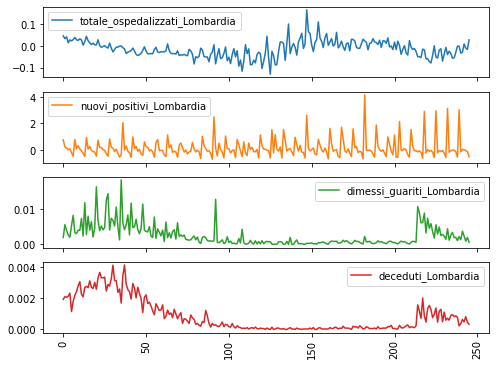

In [10]:
# check the training
train_df[regions_train[0]].plot(subplots=True)
plt.xticks(rotation=90)

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

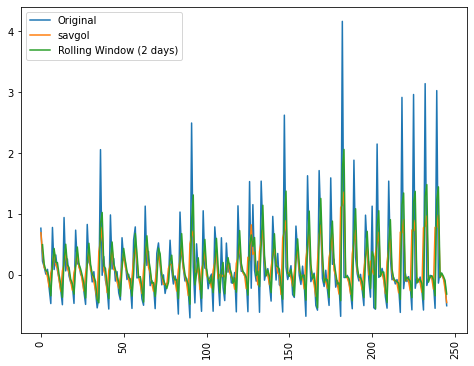

In [11]:
# check the smoothing

import copy

window_length = 3 # MUST BE ODD; if you put 7 you obtain just the trend
polyorder = 1 # Try also 2, 3, ...

savgol_smooth = copy.deepcopy(train_df)

savgol_smooth[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)] = savgol_filter(
                savgol_smooth[reg].loc[:, "{}_{}".format("nuovi_positivi", reg)],
                window_length,
                polyorder
            )

window_smooth = train_df[reg]['nuovi_positivi_Lombardia'].rolling(window=2).mean()

train_df[regions_train[0]]['nuovi_positivi_Lombardia'].plot(label = 'Original')
savgol_smooth[reg]['nuovi_positivi_Lombardia'].plot(label = 'savgol')
window_smooth.dropna().plot(label="Rolling Window (2 days)")
plt.legend()
plt.xticks(rotation=90)

To view all the figures, increase max_figures


2022-04-25 22:59:17.673247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-25 22:59:17.673283: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 22:59:17.673296: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-H65JH0S): /proc/driver/nvidia/version does not exist
2022-04-25 22:59:17.673552: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 864x576 with 0 Axes>

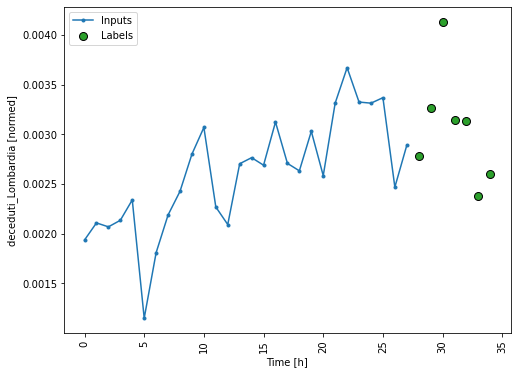

In [12]:
# Plot for viewing the batches
region = "Lombardia"
feature = "deceduti" #nuovi_positivi, dimessi_guariti, #totale_ospedalizzati
plot_feature(region, feature, max_figures=1)

In [13]:
# Creation Training set for RNN

# Single region
if len(regions_train) == 1:

    X_train = windows[regions_train[0]].train
    X_val = None
    
    if VALIDATION:
        try:
            X_val =  windows[regions_train[0]].val
        except:
           print("Cannot create X_val with the given window size or val_df not present")

# Multiple regions
elif len(regions_train) > 1:
    
    print("More than one region...")
    
    for i in range(len(regions_train)-1):
        
        X_train = windows[regions_train[i]].train.concatenate(windows[regions_train[i+1]].train)
        X_val = None
        
        if VALIDATION:
            try:
                X_val = windows[regions_train[i]].val.concatenate(windows[regions_train[i+1]].val)
            except:
                print("Cannot create X_val with the given window size or val_df not present")

In [14]:
# IN THIS WAY YOU CAN EXTRACT THE TRAINING DATASET (Solution to the problem highlighted by Nove)
# list(X_train.as_numpy_iterator())

## Multi-Steps

In [15]:
def compile_and_fit(model, X_train, MAX_EPOCHS = 200, X_val = None, patience=30):
  
  if X_val == None:
        monitor_loss = 'loss'
  else:
        monitor_loss = 'val_loss'
    
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor_loss, 
                                                    patience=patience,
                                                    mode='min')
  
  #easy_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/Othercomputers/Laptop/homework3/Data/checkpoint_' + reg + '.h5',
  #                                                     save_weights_only = False, save_freq = 'epoch', monitor = monitor_loss, mode='min', 
  #                                                     save_best_only = True, verbose = 1)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(X_train, epochs=MAX_EPOCHS,
                      validation_data=X_val,
                      callbacks=[early_stopping])    #callbacks= [early_stopping, easy_checkpoint])

  return history

In [16]:
# Current best model for PCT CHANGE

num_features = 4

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=False, kernel_regularizer = 'l2'),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [51]:
# model for PCT CHANGE

num_features = 4

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=False, kernel_regularizer = 'l2', activation='selu'),
    # Shape => [batch, out_steps*features].
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
if VALIDATION:
    history = compile_and_fit(multi_lstm_model, X_train, X_val = X_val, MAX_EPOCHS = 500, patience = 30)
else:
    history = compile_and_fit(multi_lstm_model, X_train, X_val = X_val, MAX_EPOCHS = 500, patience = 30)

Epoch 1/500
14/14 [==============================] - 1s 19ms/step - loss: 0.2097 - mean_absolute_error: 0.1211 - val_loss: 0.5277 - val_mean_absolute_error: 0.1912
Epoch 2/500
14/14 [==============================] - 0s 9ms/step - loss: 0.1959 - mean_absolute_error: 0.1288 - val_loss: 0.5020 - val_mean_absolute_error: 0.2185
Epoch 3/500
14/14 [==============================] - 0s 10ms/step - loss: 0.1901 - mean_absolute_error: 0.1352 - val_loss: 0.4912 - val_mean_absolute_error: 0.2015
Epoch 4/500
14/14 [==============================] - 0s 10ms/step - loss: 0.1816 - mean_absolute_error: 0.1289 - val_loss: 0.4823 - val_mean_absolute_error: 0.2021
Epoch 5/500
14/14 [==============================] - 0s 10ms/step - loss: 0.1755 - mean_absolute_error: 0.1316 - val_loss: 0.4754 - val_mean_absolute_error: 0.2067
Epoch 6/500
14/14 [==============================] - 0s 10ms/step - loss: 0.1705 - mean_absolute_error: 0.1323 - val_loss: 0.4701 - val_mean_absolute_error: 0.2060
Epoch 7/500
14/14

To view all the figures, increase max_figures


<Figure size 864x576 with 0 Axes>

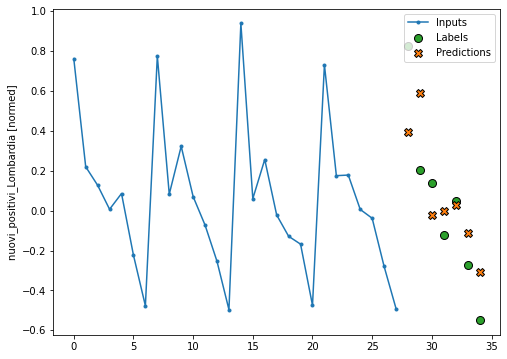

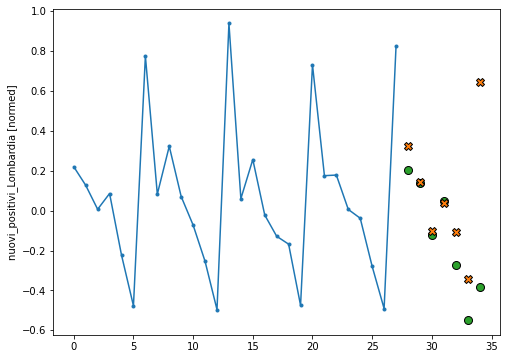

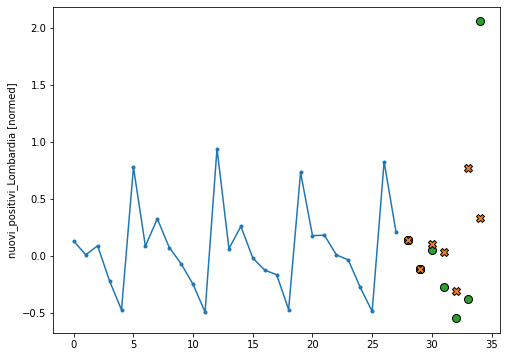

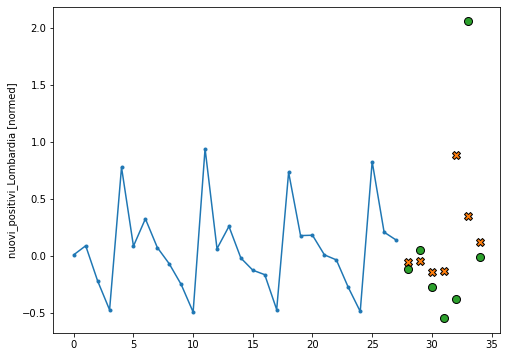

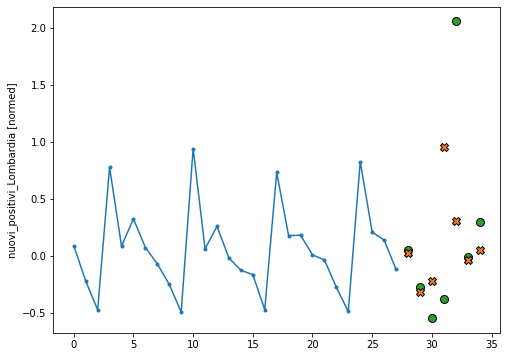

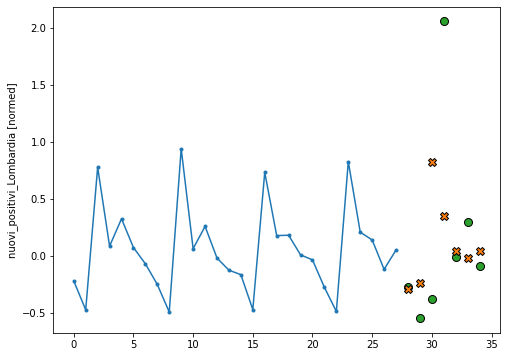

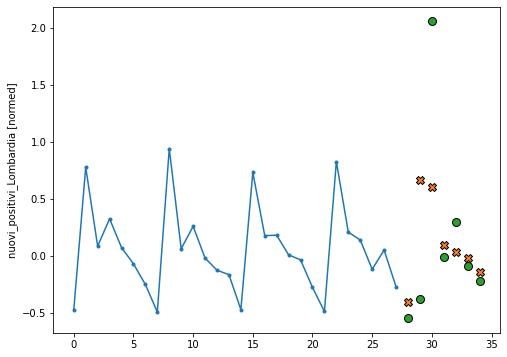

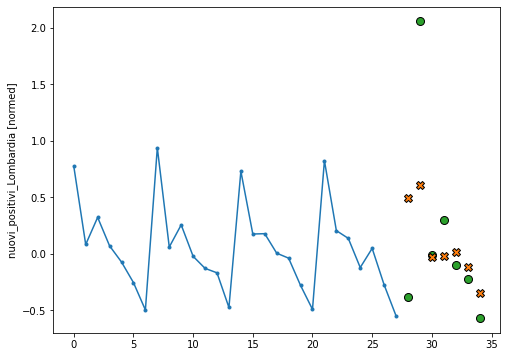

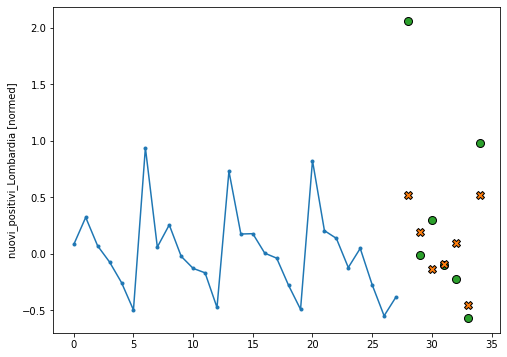

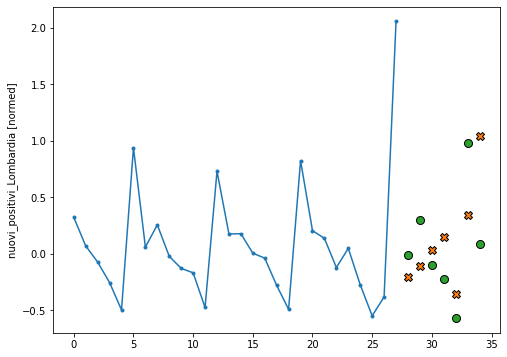

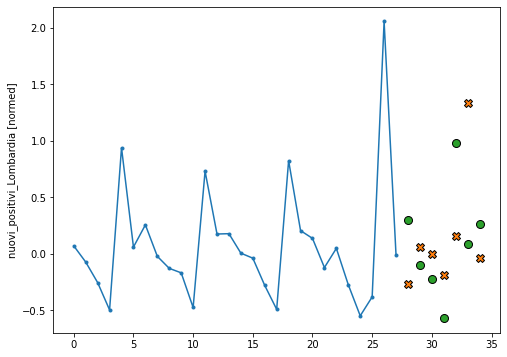

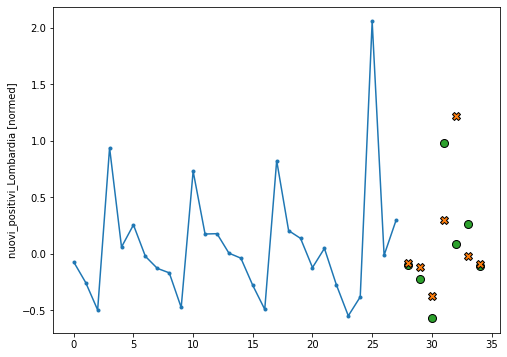

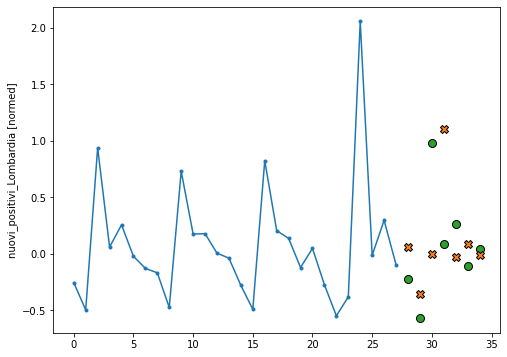

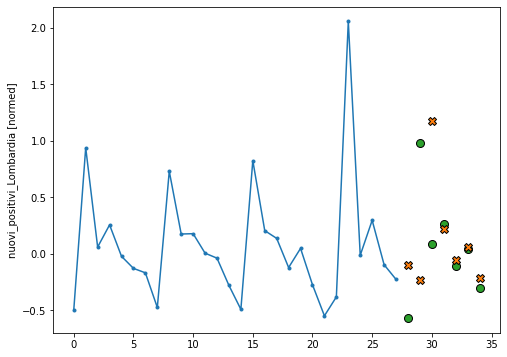

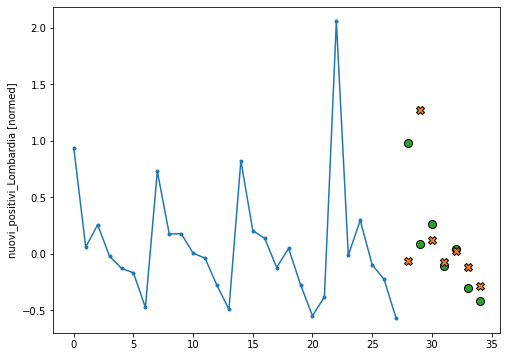

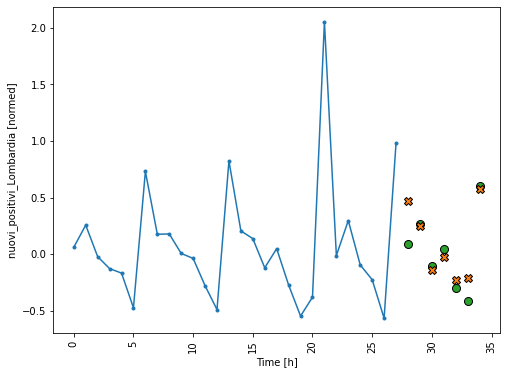

In [53]:
region = "Lombardia"
feature = "nuovi_positivi"  #nuovi_positivi, dimessi_guariti, #totale_ospedalizzati #deceduti
plot_feature(region, feature, multi_lstm_model, 30)

# THE MODEL DOES NOT LEARN NUOVI_POSITVI: I THINK IT'S BEACUSE THE OTHER FEATURES HAVE AN INCREASING AND A DECREASING TREND,
# AND THE NN IS CONFUSED. FIRST LET'S SEE IF PCT_CHANGE OR DIFF CHANGE SOMETHING ...

In [54]:
region = "Lombardia"

if VALIDATION:
    pred_x_predict = multi_lstm_model(np.array(val_df[reg].iloc[-IN_STEPS:,:]).reshape(1, IN_STEPS, 4)) 
    pred_x_predict
else:
    pred_x_predict = multi_lstm_model(np.array(train_df[reg].iloc[-IN_STEPS:,:]).reshape(1, IN_STEPS, 4))
    pred_x_predict

In [55]:
pr = tf.squeeze(pred_x_predict)
prd = pd.DataFrame(pr.numpy())

idx = test_df[reg].index[-OUT_STEPS:]

predictions = prd.rename(columns={0: 'pred_totale_ospedalizzati_' + reg, 
                                  1: 'pred_nuovi_positivi_' + reg,
                                  2: 'pred_dimessi_guariti_' + reg,
                                  3: 'pred_deceduti_' + reg},
                          index={ 0: idx[0],
                                  1: idx[1],
                                  2: idx[2],
                                  3: idx[3],
                                  4: idx[4],
                                  5: idx[5],
                                  6: idx[6]})

In [56]:
predictions

,pred_totale_ospedalizzati_Lombardia,pred_nuovi_positivi_Lombardia,pred_dimessi_guariti_Lombardia,pred_deceduti_Lombardia
281,0.022212,3.236684,0.003271,-0.001216
282,-0.023259,-0.130181,0.002267,0.000819
283,-0.006435,0.096808,0.001030,-0.001608
284,0.010039,0.041944,0.003269,-0.003493
285,-0.005345,0.040588,0.008262,0.000353
286,0.002235,-0.145858,-0.006482,0.000233
287,0.030041,-0.715118,-0.018409,-0.000557


In [57]:
test_df[reg]

,totale_ospedalizzati_Lombardia,nuovi_positivi_Lombardia,dimessi_guariti_Lombardia,deceduti_Lombardia
281,0.026042,0.442999,0.001417,0.000101
282,0.021151,5.039073,0.005109,0.000605
283,0.023198,-0.311909,0.001742,0.000756
284,0.004049,-0.049907,0.006420,0.000907
285,-0.020161,-0.073844,0.002835,0.001082
286,-0.014815,-0.298732,0.002413,0.000578
287,0.013367,-0.604990,0.001984,0.000452


In [59]:
concatenated_df = pd.concat([predictions, test_df[reg]], axis=1)

errors = pd.DataFrame()
for i in range(4):
  errors = pd.concat([errors, concatenated_df.iloc[:, i] - concatenated_df.iloc[:, i+4]], axis = 1, ignore_index=True)

In [60]:
errors    #ordine: totale_ospedalizzati	nuovi_positivi	dimessi_guariti	deceduti

,0,1,2,3
281,-0.003830,2.793685,0.001854,-0.001317
282,-0.044410,-5.169254,-0.002842,0.000214
283,-0.029633,0.408717,-0.000712,-0.002364
284,0.005990,0.091851,-0.003151,-0.004399
285,0.014817,0.114433,0.005427,-0.000729
286,0.017050,0.152874,-0.008895,-0.000345
287,0.016674,-0.110128,-0.020393,-0.001009


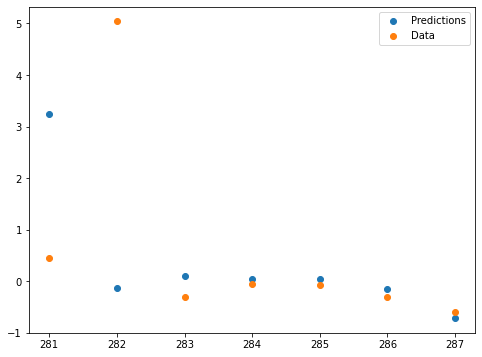

In [61]:
# Nuovi positivi 

plt.scatter(predictions.index, predictions['pred_nuovi_positivi_Lombardia'], label = 'Predictions')
plt.scatter(predictions.index, test_df[reg].iloc[-OUT_STEPS:, 1], label = 'Data')
plt.legend()

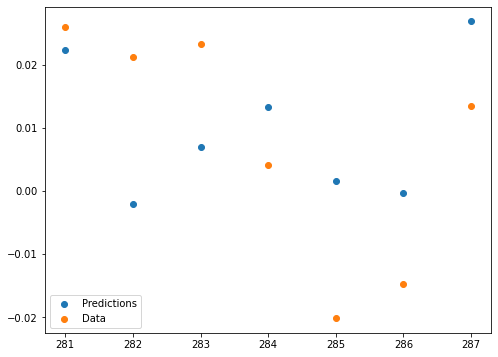

In [27]:
# Totale ospedalizzati

plt.scatter(predictions.index, predictions['pred_totale_ospedalizzati_Lombardia'], label = 'Predictions')
plt.scatter(predictions.index, test_df[reg]['totale_ospedalizzati_Lombardia'], label = 'Data')
plt.legend()

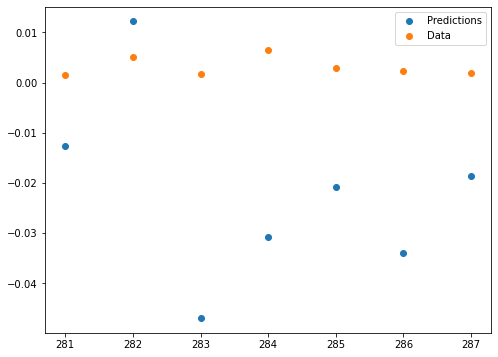

In [28]:
# Dimessi guariti

plt.scatter(predictions.index, predictions['pred_dimessi_guariti_Lombardia'], label = 'Predictions')
plt.scatter(predictions.index, test_df[reg]['dimessi_guariti_Lombardia'], label = 'Data')
plt.legend()

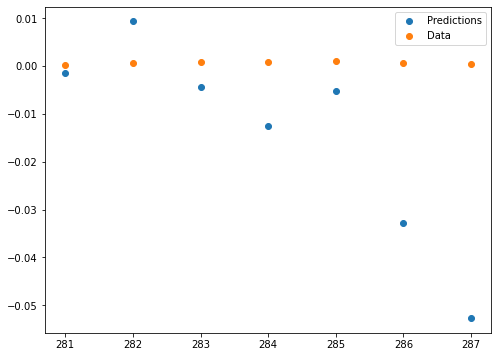

In [29]:
# Deceduti 

plt.scatter(predictions.index, predictions['pred_deceduti_Lombardia'], label = 'Predictions')
plt.scatter(predictions.index, test_df[reg]['deceduti_Lombardia'], label = 'Data')
plt.legend()

In [30]:
prova = np.ones((IN_STEPS,4)).reshape(1,IN_STEPS,4)
multi_lstm_model.predict(prova)

array([[[-1.9495077e-03,  9.6818328e-02, -2.0028260e-02, -4.8601441e-03],
        [-1.5853891e-02,  2.8634524e-01,  8.7463893e-03,  1.5898956e-02],
        [-1.5500677e-02, -2.6591885e-01,  3.3794204e-04,  4.7133444e-03],
        [-6.5649329e-03, -1.6868129e-01,  1.9951342e-02,  7.6810285e-03],
        [ 4.9600517e-03,  2.5743893e-01,  9.5622987e-03,  2.1294670e-03],
        [ 1.7090533e-03,  4.2442468e-01,  3.3227177e-03,  1.7429369e-02],
        [-1.6338438e-02,  3.0123126e-02, -1.8525867e-02, -3.7676845e-02]]],
      dtype=float32)

### Back to original scale

In [62]:
init = df_by_region[reg].iloc[-time_steps_for_test-1,:]
init = pd.DataFrame(init).T

initial = init.rename(columns={'totale_ospedalizzati_' + reg: 'pred_totale_ospedalizzati_' + reg, 
                               'nuovi_positivi_' + reg: 'pred_nuovi_positivi_' + reg,
                               'dimessi_guariti_' + reg: 'pred_dimessi_guariti_' + reg,
                               'deceduti_' + reg: 'pred_deceduti_' + reg} )

pred_original_scale = (1 + predictions).cumprod() * initial.iloc[0,:]

In [63]:
# Error with original data

idx_true = df_by_region[reg].iloc[-time_steps_for_test:,:].index
idx_pred = pred_original_scale.index
true_test = df_by_region[reg].iloc[-time_steps_for_test:,:].rename(index={idx_true[0]: idx_pred[0], 
                                                                          idx_true[1]: idx_pred[1], 
                                                                          idx_true[2]: idx_pred[2], 
                                                                          idx_true[3]: idx_pred[3], 
                                                                          idx_true[4]: idx_pred[4], 
                                                                          idx_true[5]: idx_pred[5], 
                                                                          idx_true[6]: idx_pred[6]} )

original_concatenated_df = pd.concat([pred_original_scale, true_test], axis=1 )

original_errors = pd.DataFrame()
for i in range(4):
  original_errors = pd.concat([original_errors, original_concatenated_df.iloc[:, i] - original_concatenated_df.iloc[:, i+4]], axis = 1, ignore_index=True)
  
original_err = original_errors.rename(columns={0: 'totale_ospedalizzati_' + reg, 
                                               1: 'nuovi_positivi_' + reg,
                                               2: 'dimessi_guariti_' + reg,
                                               3: 'deceduti_' + reg} )

original_error = (original_err * std) + mean

original_error_perc = (original_error / true_test) * 100

In [64]:
original_error_perc

,totale_ospedalizzati_Lombardia,nuovi_positivi_Lombardia,dimessi_guariti_Lombardia,deceduti_Lombardia
281,-0.373267,193.602736,0.185179,-0.131703
282,-4.706028,-57.711865,-0.098113,-0.110319
283,-7.465822,-32.593305,-0.169078,-0.346275
284,-6.913761,-26.076709,-0.481669,-0.784263
285,-5.506157,-16.942988,0.056913,-0.856542
286,-3.870788,1.163118,-0.830967,-0.890711
287,-2.289076,-27.040857,-2.849307,-0.990647


In [34]:
original_errors      # con lstm(32) e dropout = 0.1 + giorni 2021

,0,1,2,3
281,-4.330170,2521.429980,-34737.726996,-66.655681
282,-31.734528,-8125.015045,-17589.807127,276.875938
283,-51.632660,-4410.062639,-138124.125666,74.165693
284,-40.990326,-4270.881676,-226634.647514,-459.917305
285,-14.112213,-2817.266313,-281501.478188,-707.911451
286,3.393677,-1310.472834,-363786.735420,-2014.552837
287,19.615753,180.535167,-409223.542635,-4022.169093


In [35]:
original_errors    # con lstm(16) e dropout = 0.1 e activation function selu

,0,1,2,3
281,-4.330170,2521.429980,-34737.726996,-66.655681
282,-31.734528,-8125.015045,-17589.807127,276.875938
283,-51.632660,-4410.062639,-138124.125666,74.165693
284,-40.990326,-4270.881676,-226634.647514,-459.917305
285,-14.112213,-2817.266313,-281501.478188,-707.911451
286,3.393677,-1310.472834,-363786.735420,-2014.552837
287,19.615753,180.535167,-409223.542635,-4022.169093


In [36]:
original_errors  # con lstm(16) e dropout = 0.1

,0,1,2,3
281,-4.330170,2521.429980,-34737.726996,-66.655681
282,-31.734528,-8125.015045,-17589.807127,276.875938
283,-51.632660,-4410.062639,-138124.125666,74.165693
284,-40.990326,-4270.881676,-226634.647514,-459.917305
285,-14.112213,-2817.266313,-281501.478188,-707.911451
286,3.393677,-1310.472834,-363786.735420,-2014.552837
287,19.615753,180.535167,-409223.542635,-4022.169093


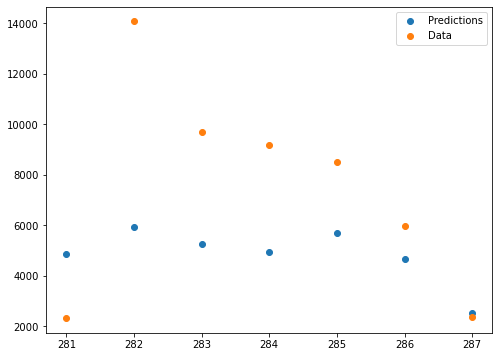

In [37]:
# nuovi_positivi    totale_ospedalizzati   dimessi_guariti    deceduti

plt.scatter(pred_original_scale.index, pred_original_scale['pred_nuovi_positivi_Lombardia'], label = 'Predictions')
plt.scatter(pred_original_scale.index, df_by_region[reg].iloc[-time_steps_for_test:,:]['nuovi_positivi_Lombardia'], label = 'Data')
plt.legend()

# Comments

The model is doing way better than yesterday (the key thing was to put shuffle=False in the creation of the training dataset). Two problems:
- The network has issues to learn the behaviour of "nuovi_positivi" beacuse the trend is very oscillating. Applying the Savitzky-Golay filter the network performs quite well but has it still struggles.
- IMPORTANT: Since the trend of "deceduti" and "dimessi_guariti" is increasing, we must use pct_change or diff in the model. Otherwise the model will learn to predict in [a,b] with a,b in R, but the next seven days will be surely greater than b!